In [2]:
import struct
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [44]:
# read first waveform file
file = "tester"
nevent1 = 0
xList1 = []
tList1 = []
tDAQ1  = []
event1 = []


#f1 = open("../Output/wave0.dat", "rb")
#f1 = open("../../Messdaten/WS1920/test/na22-dat1.dat", "rb")
#f1 = open(dir_out+sample+'.dat', "rb")
f1 = open("./"+file+".dat", "rb")
notEOF = True
while notEOF and nevent1 < 100000000:
   # read header: record, boardID, channel, pattern, event, time_ns
   s = f1.read(24)
   if len(s) != 24:
      notEOF = False
      break
   record,boardID,channel,pattern,evt,time_ns = struct.unpack("<LLLLLL", s)
   #print record,boardID,channel,pattern,evt,time_ns
   # read data: record = Byte length of the waveform event (16 bit per sample) + 24 (6*4Byte) header length 
   s = f1.read(record-24)
   if len(s) != (record-24):
      notEOF = False
      break
   data = struct.unpack("<"+str(int((record-24)/2))+"H", s)
  # determine the baseline signal (average of first 10 samples)
   n_average = 20 
   x0=0
   for i in range(n_average):
      x0 = x0 + data[i]
   x0 = x0 / n_average

   # find the maximum peak in the waveform event (gliding average of 10 samples)
   imax = 0
   xmax = 0.
   xsum = 0.
   for i in range(n_average,int((record-24)/2)):
      xsum = xsum + data[i-n_average] - data[i]
      #xsum =  x0 - data[i]
      if xmax < xsum:
         xmax = xsum
         imax = i
   xList1.append(xmax/n_average)
   tList1.append(imax * 8)
   tDAQ1.append(time_ns * 8)
   event1.append(evt)
   nevent1 = nevent1 + 1
f1.close()
print("done")


done


In [28]:
#array=np.arange(0, nBins*binSize, binSize)
#np.sum(n1[800:850]) + np.sum(n1[900:950])

Number of events:  7723


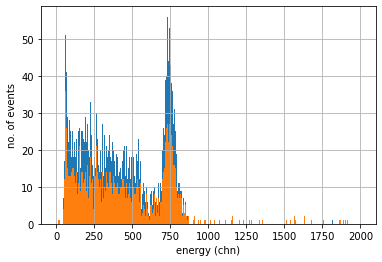

In [49]:
# plot results
binSize=2
nBins=1000
n1, bins, patches1 = plt.hist(xList1[:int(nevent1*5/5)], nBins, range=(0,nBins*binSize))

n1, bins, patches1 = plt.hist(xList1[:int(nevent1*3/5)], nBins, range=(0,nBins*binSize))

bin_centers = bins[:-1] + binSize/2
plt.xlabel('energy (chn)')
plt.ylabel('no. of events') 
plt.grid(True)
print ("Number of events: ",nevent1)
plt.savefig("./"+file+ ".png")
table = pd.DataFrame([bin_centers, n1]).T
table.to_csv("./"+file+ '.txt', index=None, sep=' ', mode='a', header=['bin_center', 'N_events'])
#plt.xlim(0,250)
plt.show()

In [67]:
#unnötig
#with open('Peaks.txt', "w") as file_w:
 #   file.write("file name \t Peak at (CH) \t sigma \n")

[ 1.73188635e+04 -1.72461222e+01  8.39029959e+02]


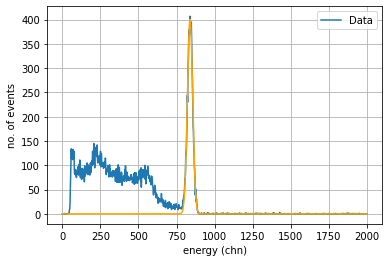

In [33]:

def gauss (x,A,sigma,µ):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-µ)**2/(2*sigma**2))

def gauss_const (x,A,sigma,µ,c):
    return A/np.sqrt(2*np.pi*sigma**2)*np.exp(-(x-µ)**2/(2*sigma**2))+c

dat_name = 'Analysis/Na22_data'
dat = np.genfromtxt("./" +file+ '.txt', skip_header = 1)
x,y = dat.T 

beg_ch = 1400
end_ch = 1600
#p_0 = [500, 30, (end_ch+beg_ch)/2,6]
#par1, cov= curve_fit(xdata = x[int(beg_ch/2):int(end_ch/2)], ydata = y[int(beg_ch/2):int(end_ch/2)], f =gauss_const,p0= p_0)
#print(par1)
beg_ch = 750
end_ch = 900
p_0 = [500, 30, (end_ch+beg_ch)/2]
par2, cov= curve_fit(xdata = x[int(beg_ch/2):int(end_ch/2)], ydata = y[int(beg_ch/2):int(end_ch/2)], f =gauss, p0= p_0)
print(par2)



plt.plot(x, y, '-', label = 'Data')
#plt.plot(x, gauss_const(x, par1[0], par1[1], par1[2],par1[3]), color='orange', label = 'Gaussian fit')
plt.plot(x, gauss(x, par2[0], par2[1], par2[2]), color='orange')


plt.xlabel('energy (chn)')
plt.ylabel('no. of events')
plt.legend()
plt.grid()
#plt.savefig(f'{dat_name}_fit.png')
#plt.xlim(0,250)
plt.show()

if True:
    with open('./'+file+'_Peaks.txt', "a") as file_write:
        #file_write.write(f"{file} \t {par1[2]} \t {par1[1]} \n")
        file_write.write(f"{file} \t {par2[2]} \t {par2[1]} \n")

839.0299586831686 17.246122167329563


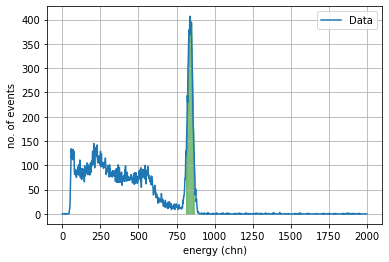

In [38]:
def integrate(mu, sig, dat_name,const_offset=0):
    sig=np.abs(sig)
    dat = np.genfromtxt("./"+dat_name+ '.txt', skip_header = 1)
    x,y = dat.T
    
    von = int((mu-1.5*sig)/2)
    bis = int((mu+1.5*sig)/2)
    print(mu,sig)
    plt.plot(x, y, '-', label = 'Data')
    plt.fill_between(x[von:bis], y[von:bis], color = "green", alpha = 0.5)
    plt.xlabel('energy (chn)')
    plt.ylabel('no. of events')
    plt.legend()
    plt.grid()
    plt.savefig(f'{dat_name}_fit.png')
    plt.show()
    
    return np.sum(np.array(y[von:bis]-const_offset))


if True:
    with open('./'+file+'_Peaks.txt', "a") as file_write:
        #file_write.write(f"{integrate(par1[2], par1[1],file, par1[3])}\n")
        file_write.write(f"{integrate(par2[2], par2[1],file)}\n")


In [19]:
prop = {"Cs137": [2.8*10**5, 30.2, [662], [7997]], "Na22": [1.1*10**4, 2.6,[511,1276], [833,125]], "Co60": [6.39*10**4, 5.27, [1173, 1332], [1263, 895]], "Co57": [6.01*10**6, 0.744, [122],[697354]]}

def epsilon(el, i):
    lam = np.log(2)/(prop[el][1]*365.25)
    if el != "Co57":
        time = 236
    else:
        time = 92
    phi = prop[el][0]*np.exp(-lam*time)/(np.pi*4*0.215**2)
    R = phi*np.pi*0.0255**2
    return prop[el][3][i]/(300*R)

elements = ["Cs137", "Na22", "Co60", "Co57"]

for i in elements:
    print(i, epsilon(i, 0))
    try:
        print(i, epsilon(i, 1))
    except:
        pass


Cs137 0.027475457629656464
Na22 0.08527021572456664
Na22 0.012795650618932569
Co60 0.020396038541530156
Co60 0.014453249797838076
Co57 0.13906833620928188
